# DATA PREPROCESSING

# Installing Libraries

- Contraction is used to process the raw data (text), by expanding the contraction (e.g.,"can't" to "cannot" or "it's" to "it is"), making text cleaner and more consistent for analysis.
- Pandas is used for analyzing and cleaning the dataset.
- Matplotlib, seaborn and wordcloud, are use to visualize trends and patterns.



In [105]:
!pip install pandas matplotlib seaborn wordcloud
!pip install contractions

In [106]:
# Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from datetime import datetime


## Installing libraries for NLP process

In [107]:
import re # Regular, to peform text cleaning (remove urls, special characters and extra spaces)
import nltk # NLTK is used for NLP process mainly in text preprocessing (Tokenization, stopword removal, lemmatization, POS taagging)

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
from nltk.corpus import wordnet
from nltk import pos_tag
from contractions import fix #To expand contracted words like "can't" to "cannot".

# Download necessary NLTK data
nltk.download('punkt_tab') # for tokenizing sentences or words
nltk.download('punkt')
nltk.download('wordnet') # For Wordnet, used in lemmatization to access synonyms, definations, and for lemmatization
nltk.download('omw-1.4')  # WordNet multilingual extensions, to support multilingual
nltk.download('averaged_perceptron_tagger_eng') # For part-of-speech tagging
nltk.download('stopwords') # For stopword removal during text preprocessing


[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /root/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [108]:
# Load the Smartphone dataset
file_path = '/content/drive/MyDrive/SEM 5/DS PROJ/DSP/Apple and Samsung Smartphones Dataset2.csv'
df = pd.read_csv(file_path)

# Display basic infor of Smartphone dataset
print("Dataset Overview:")
print(df.info())
print("\nSample Data:")
print(df.head())
num_tweets = len(df)
print(f"Number of tweets: {num_tweets}")

Dataset Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8850 entries, 0 to 8849
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   conversation_id_str  8850 non-null   float64
 1   created_at           8850 non-null   object 
 2   favorite_count       8850 non-null   int64  
 3   full_text            8850 non-null   object 
 4   lang                 8850 non-null   object 
 5   reply_count          8850 non-null   int64  
 6   retweet_count        8850 non-null   int64  
 7   smartphone           8850 non-null   object 
 8   Month                8850 non-null   int64  
 9   Year                 8850 non-null   int64  
dtypes: float64(1), int64(5), object(4)
memory usage: 691.5+ KB
None

Sample Data:
   conversation_id_str       created_at  favorite_count  \
0         1.870000e+18  12/12/2024 9:39               0   
1         1.870000e+18  12/12/2024 9:37               0   
2         1.870

## Handling Missing Values & Duplicates

In [109]:
# Check for missing values
print("\nMissing Data:")
print(df.isnull().sum())

# Drop rows with missing values in critical columns (if any)
df = df.dropna(subset=['full_text', 'created_at'])
# Drop duplicates (if any)
df = df.drop_duplicates()

# Number of rows after dropping
num_tweets = len(df)
print(f"Number of tweets after dropping: {num_tweets}")


Missing Data:
conversation_id_str    0
created_at             0
favorite_count         0
full_text              0
lang                   0
reply_count            0
retweet_count          0
smartphone             0
Month                  0
Year                   0
dtype: int64
Number of tweets after dropping: 8850


## Text preprocessing

1.   Mentions (@username) are removed because username is not necessary in this sentiment analysis project
2.   Contractions (e.g., "can't" → "cannot") are expanded using the contractions.fix() function
3.   URLs are removed using regular expressions
4.   Special characters and punctuation are removed, keeping only alphanumeric characters and dots (___)
5.   The text is converted to lowercase
6.   Remove extra whitespace to ensure consistent spacing
7.   The text is tokenized into individual words using word_tokenize() and assign POS tags using pos_tag(token)
7.   Lemmatized using WordNetLemmatizer, into their base forms using POS tags, excluding custom stopwords and non-lemmatizable words.
8.   The processed tokens are joined back into a single string

In [110]:
# List of custom stopwords to retain from removing, including "no" and "not"
default_stopwords = set(stopwords.words('english'))
custom_stopwords = default_stopwords - {'no', 'not', 'nor', 'none', 'never', 'neither', 'without', 'against',
                                        'but', 'however', 'though', 'although',
                                        'because', 'since', 'due to', 'with'}


# Words that should not be lemmatized
non_lemmatizable_words = {'iphone16', 'iphone16plus', 'iphone16pro', 'iphone16promax', "ios", 'iphone15', 'iphone15plus', 'iphone15pro', 'iphone15promax',
                          'samsunggalaxy23', 'samsunggalaxys23plus', 'samsunggalaxys23ultra', 'samsunggalaxy24', 'samsunggalaxys24plus', 'samsunggalaxys24ultra',
                          'ios17', 'ios18', 'dynamic island', 'a17bionic', 'a18chip', 'usb-c', 'lightning port', 'pro motion', 'ceramic shield',
                          'snapdragon', 'exynos', '120hz', 'amozed', 'one ui',
                          '5g', 'refresh rate', 'fast charging', 'screen size'
                          }

# Function to map POS tags to WordNet tags
def get_wordnet_pos(tag):
    if tag.startswith('J'):
        return wordnet.ADJ
    elif tag.startswith('V'):
        return wordnet.VERB
    elif tag.startswith('N'):
        return wordnet.NOUN
    elif tag.startswith('R'):
        return wordnet.ADV
    else:
        return wordnet.NOUN  # Default to noun

# Function for text preprocessing
def preprocess_text(text):
    # Remove mentions
    text = re.sub(r'@\w+', '', text)
    # Expand contractions (assuming `fix()` function is defined elsewhere)
    text = fix(text)
    # Remove URLs
    text = re.sub(r'http\S+|www\.\S+', '', text)
    # Remove special characters and punctuation, but keep numbers and dots
    text = re.sub(r'[^a-zA-Z0-9.\s]', '', text)
    # Convert to lowercase
    text = text.lower()
    # Remove redundant whitespaces
    text = re.sub(r'\s+', ' ', text).strip()

    # Tokenize and POS tag
    tokens = word_tokenize(text)
    pos_tags = pos_tag(tokens)
    lemmatizer = WordNetLemmatizer()

    # Enhanced: Edge case handling for empty text
    if not tokens:
        return ''  # Return an empty string if no valid tokens remain

    # Processing tokens with enhanced handling
    processed_tokens = [
        lemmatizer.lemmatize(word, get_wordnet_pos(tag))
        if word.isalpha() and word not in custom_stopwords and word not in non_lemmatizable_words
        else word
        for word, tag in pos_tags
    ]

    return ' '.join(processed_tokens)

# Apply preprocessing to `full_text`
df['cleaned_text'] = df['full_text'].astype(str).apply(preprocess_text)
df = df.drop(columns=['created_at'])


- The preprocess_text function is applied to the full_text column, and the cleaned text is stored in a new column, cleaned_text.

In [111]:
sample_text = "Samsung s24 is cheaper than iphone 16 pro max"
print(preprocess_text(sample_text))


samsung s24 is cheap than iphone 16 pro max


In [112]:
# Display preprocessed data
print("\nSample of Preprocessed Data:")
print(df[['full_text', 'cleaned_text']].head())


Sample of Preprocessed Data:
                                           full_text  \
0  @theapplehub stupid updated. I've 1 iPhone15. ...   
1  What are all the noticeable changes there in i...   
2  @MacRumors I'm having worst bqttery on my iPho...   
3  @techstarsrk So the experience of ColourTouch ...   
4                     @Macosta2547 An iPhone15ProMax   

                                        cleaned_text  
0  stupid update . i have 1 iphone15 . update is ...  
1  what are all the noticeable change there in ip...  
2       i am having bad bqttery on my iphone15promax  
3  so the experience of colourtouch hellooneui ip...  
4                                  an iphone15promax  


# Step 2: Exploratory Data Analysis (EDA)

## Summarizing favorite, reply and retweet counts columns

In [113]:
# Summarize analysis of favorite, reply, and retweet counts
summary_stats = df[['favorite_count', 'reply_count', 'retweet_count']].describe()
print("Summary Statistics:")
print(summary_stats)

Summary Statistics:
       favorite_count  reply_count  retweet_count
count     8850.000000  8850.000000    8850.000000
mean         9.943051     1.723390       0.722599
std        214.758496    23.981108      15.088850
min          0.000000     0.000000       0.000000
25%          0.000000     0.000000       0.000000
50%          0.000000     0.000000       0.000000
75%          1.000000     1.000000       0.000000
max      16845.000000  1943.000000    1020.000000


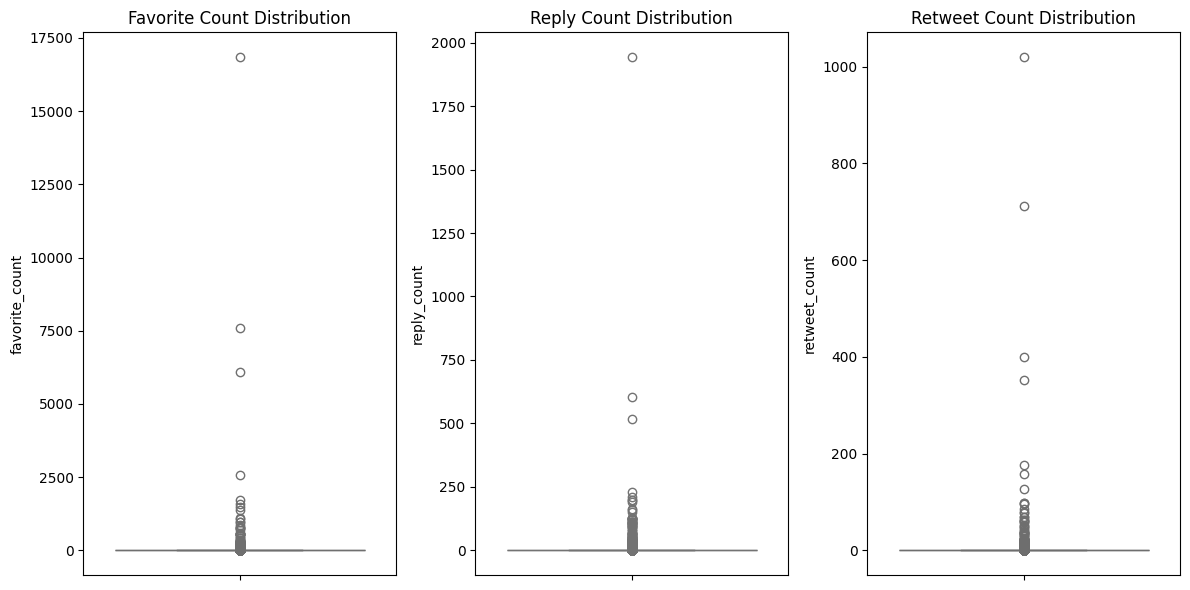

In [114]:
# Boxplots for engagement metrics
plt.figure(figsize=(12, 6))
plt.subplot(1, 3, 1)
sns.boxplot(y=df['favorite_count'], color='skyblue')
plt.title('Favorite Count Distribution')

plt.subplot(1, 3, 2)
sns.boxplot(y=df['reply_count'], color='lightgreen')
plt.title('Reply Count Distribution')

plt.subplot(1, 3, 3)
sns.boxplot(y=df['retweet_count'], color='lightcoral')
plt.title('Retweet Count Distribution')

plt.tight_layout()
plt.show()

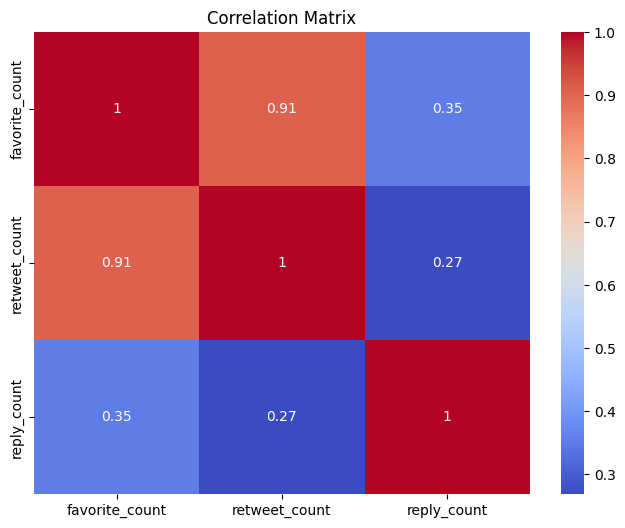

In [115]:
# Correlation matrix
plt.figure(figsize=(8, 6))
sns.heatmap(df[['favorite_count', 'retweet_count', 'reply_count']].corr(), annot=True, cmap='coolwarm')
plt.title("Correlation Matrix")
plt.show()


Here are the insights got from exploratory numerical columns, favorite, reply and retweet count columns.

- Understanding Engagement Levels of smartphone by reflecting the number of these 3 columns to the text.
- Identifying min, max, average and outliers for each numerical columns to identify trends and anomalies

## Smartphones EDA

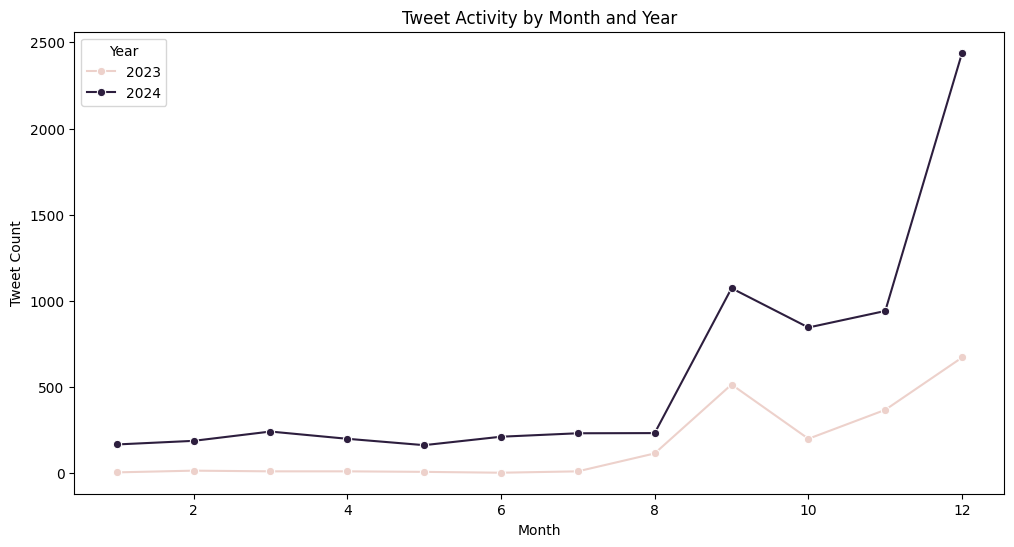

In [116]:
# Temporal analysis: Tweets by year and month
year_month_counts = df.groupby(['Year', 'Month']).size().reset_index(name='tweet_count')

plt.figure(figsize=(12, 6))
sns.lineplot(data=year_month_counts, x='Month', y='tweet_count', hue='Year', marker='o')
plt.title('Tweet Activity by Month and Year')
plt.xlabel('Month')
plt.ylabel('Tweet Count')
plt.legend(title='Year')
plt.show()

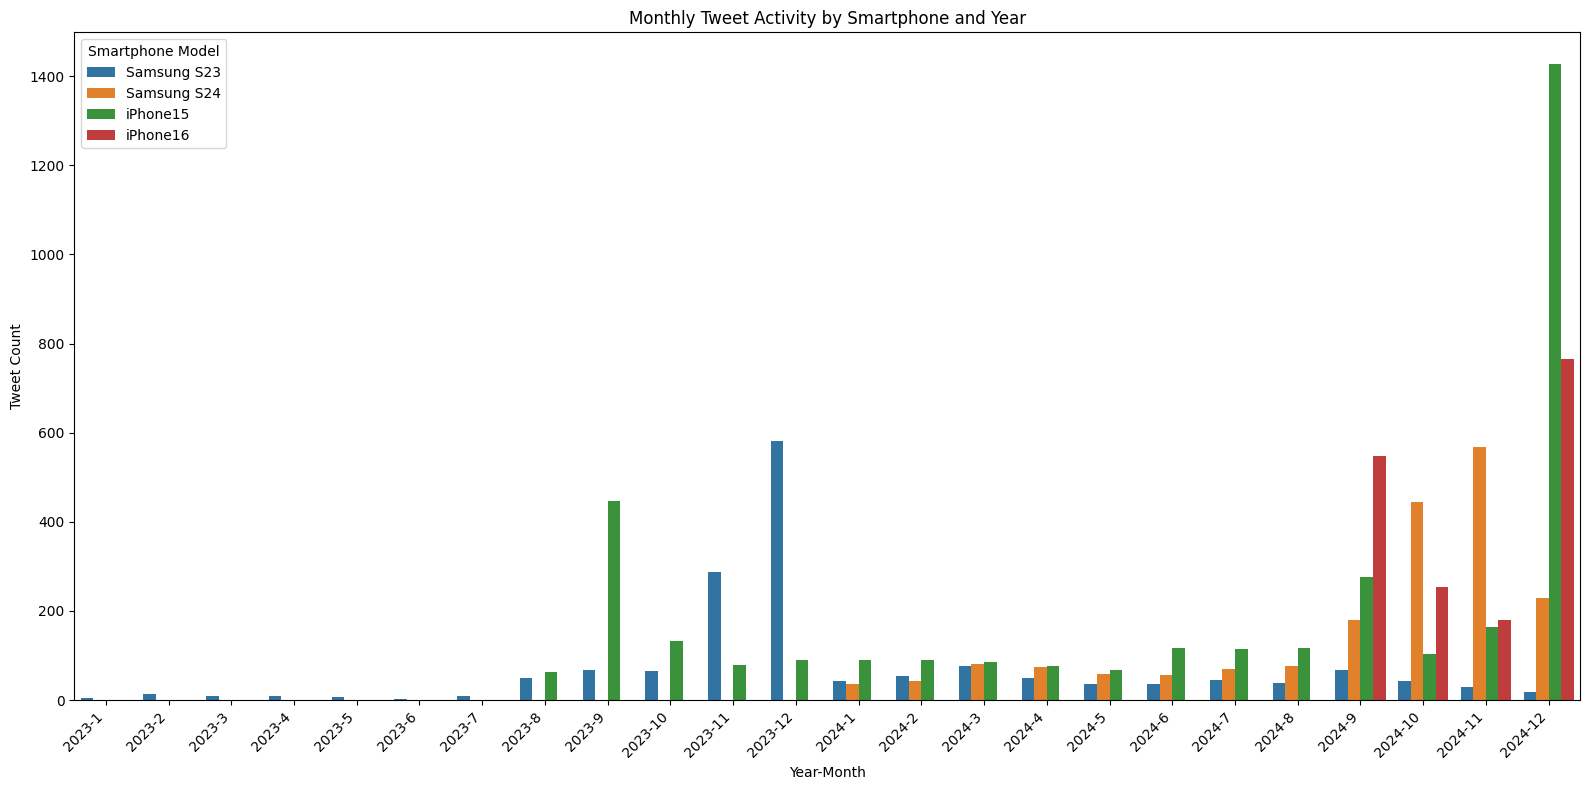

In [117]:
# Smartphone-specific tweet analysis (Year and Month)
tweets_by_smartphone = df.groupby(['smartphone', 'Year', 'Month']).size().reset_index(name='tweet_count')

# Combine Year and Month into a single column for easier plotting
tweets_by_smartphone['Year-Month'] = tweets_by_smartphone['Year'].astype(str) + '-' + tweets_by_smartphone['Month'].astype(str)

plt.figure(figsize=(16, 8))
sns.barplot(data=tweets_by_smartphone, x='Year-Month', y='tweet_count', hue='smartphone')
plt.title('Monthly Tweet Activity by Smartphone and Year')
plt.xlabel('Year-Month')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better visibility
plt.legend(title='Smartphone Model')
plt.tight_layout()
plt.show()


- Data Validation
> To help me ensure the dataset is accurate or not based on month and year of their launching and purchasing the products.

- Trend Analysis
> To identify trends of monthly tweet activity by smartphones. Peak in activity may correspond to product launches, announcement, events and comparison with between models or different smartphones.



    smartphone  tweet_count
0  Samsung S23         1647
1  Samsung S24         1917
2     iPhone15         3539
3     iPhone16         1747


<ipython-input-118-77361496683c>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=model_counts, x='smartphone', y='tweet_count', palette='viridis')


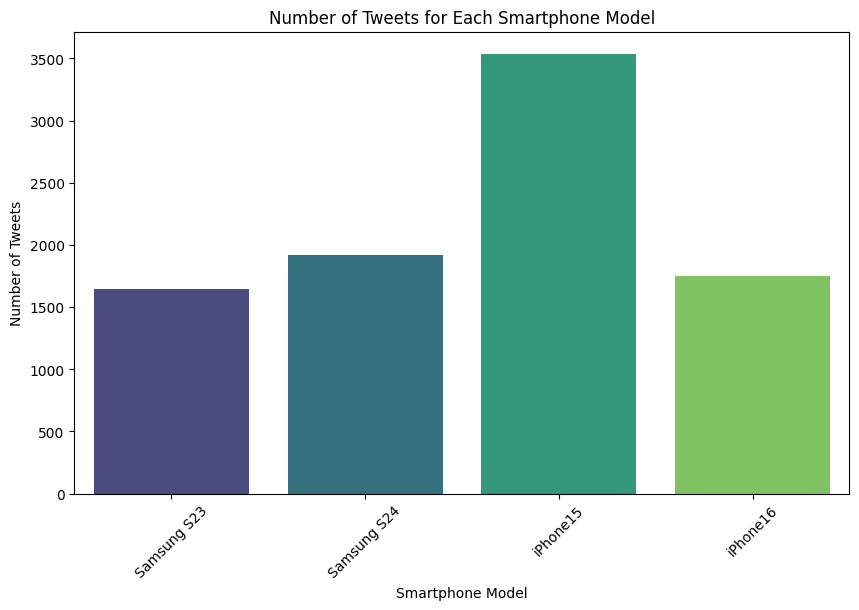

In [118]:
# Group by smartphone and count unique conversation IDs
model_counts = df.groupby('smartphone')['conversation_id_str'].size().reset_index(name='tweet_count')
print(model_counts)

# Plotting bar chart
plt.figure(figsize=(10, 6))
sns.barplot(data=model_counts, x='smartphone', y='tweet_count', palette='viridis')
plt.title('Number of Tweets for Each Smartphone Model')
plt.xlabel('Smartphone Model')
plt.ylabel('Number of Tweets')
plt.xticks(rotation=45)
plt.show()

- Understanding the popularity each smartphone

> iPhone 15 is the most disccused model with 3539 tweet count, nearly double the tweet count of iPhone16.

> Samsung s24 has slightly more engagement than s23, reflecting user interest in the newer falgship

> Apple models collectively have higher tweet count than samsung, potetially reflecting stronger social media engagement, due to its controversional, and loyalty customers.

> Iphone 16 and Samsung s24 are the new model launched by 2024, so they may need more time to generate buzz.

In [119]:
# Word cloud generation
def generate_wordcloud(data, title):
    text = " ".join(data)
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
    plt.figure(figsize=(10, 6))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(title, fontsize=16)
    plt.axis('off')
    plt.show()

Generating word clouds...


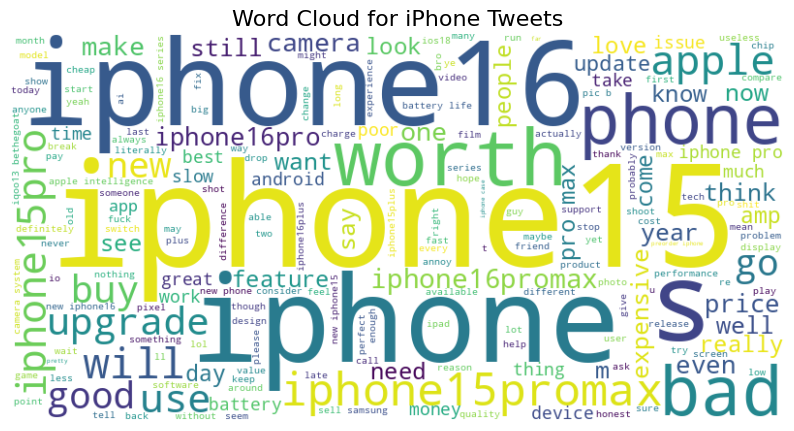

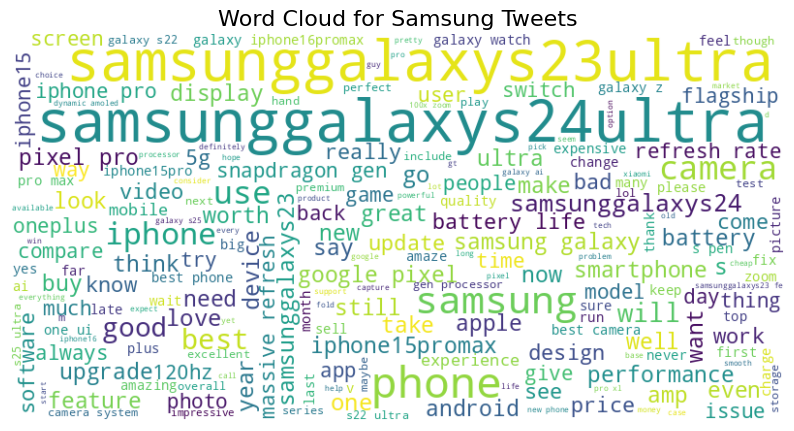

In [120]:
# Generate word clouds for iPhone and Samsung
dice_iphone = df[df['smartphone'].str.contains('iPhone', case=False, na=False)]
dice_samsung = df[df['smartphone'].str.contains('Samsung', case=False, na=False)]

print("Generating word clouds...")
generate_wordcloud(dice_iphone['cleaned_text'], 'Word Cloud for iPhone Tweets')
generate_wordcloud(dice_samsung['cleaned_text'], 'Word Cloud for Samsung Tweets')


# Visualize keyword counts

In [121]:
# Step 5: Sentiment Analysis Preparation
negative_keywords = ['annoying', 'bad', 'broken', 'buggy', 'complicated', 'disappointing', 'disliked', 'expensive',
                     'frustrated', 'frustrating', 'glitchy', 'hated', 'irritating', 'laggy', 'lacking', 'not worth',
                     'outdated', 'overheating', 'overhyped', 'overpriced', 'poor', 'problematic', 'slow', 'terrible',
                     'unacceptable', 'unimpressed', 'unreliable', 'unsatisfied', 'unstable', 'unresponsive', 'useless',
                     'weak', 'worst']

positive_keywords = ['affordable', 'amazing', 'awesome', 'beautiful', 'best', 'elegant', 'excellent', 'exceptional',
                     'fantastic', 'fast', 'favorite', 'flawless', 'great', 'iconic', 'impressive', 'incredible',
                     'innovative', 'love', 'next-level', 'outstanding', 'perfect', 'powerful', 'premium', 'reliable',
                     'revolutionary', 'smooth', 'stylish', 'superior', 'top-notch', 'unique', 'user-friendly', 'worth']

character_keywords = ['5g', 'ios17', 'ios18', 'a17bionic', 'a18chip', 'accessibility', 'battery', 'battery health', 'bezel', 'bluetooth', 'brightness',  'bugs', 'build quality', 'camera', 'cellular', 'charging', 'chipset', 'cinematic mode', 'colors',  'comparison', 'customization', 'design', 'display', 'dual sim', 'dynamic island', 'ecosystem',  'endurance', 'esim', 'fast charging', 'features', 'gaming', 'integration', 'ios', 'mag safe',  'material', 'multitasking', 'night mode', 'notch', 'oled', 'operating system', 'performance',  'port', 'portrait mode', 'price', 'processor', 'ram', 'refresh rate', 'resolution', 'size',  'software', 'speed', 'stabilization', 'storage', 'updates', 'video quality', 'vs android',  'vs samsung', 'weight', 'wi-fi', 'wireless charging', 'zoom']

apple_keywords = ['iphone16', 'iphone16plus', 'iphone16pro', 'iphone16promax', 'iphone15', 'iphone15plus', 'iphone15pro', 'iphone15promax']
samsung_keywords = ['SamsungGalaxyS23', 'SamsungGalaxyS23Plus', 'SamsungGalaxyS23Ultra', 'SamsungGalaxyS24', 'SamsungGalaxyS24Plus', 'SamsungGalaxyS24Ultra']

In [122]:
# Pre-defined apple_df and samsung_df
apple_df = df[df['cleaned_text'].str.contains('Apple', case=False, na=False)]
samsung_df = df[df['cleaned_text'].str.contains('Samsung', case=False, na=False)]

for keyword in negative_keywords + positive_keywords + character_keywords:
    apple_df[keyword] = apple_df['cleaned_text'].str.contains(keyword, case=False, na=False)
    samsung_df[keyword] = samsung_df['cleaned_text'].str.contains(keyword, case=False, na=False)

# Calculate keyword counts for Apple
apple_negative_counts = apple_df[negative_keywords].sum().sort_values(ascending=False)
apple_positive_counts = apple_df[positive_keywords].sum().sort_values(ascending=False)
apple_character_counts = apple_df[character_keywords].sum().sort_values(ascending=False)

# Calculate keyword counts for Samsung
samsung_negative_counts = samsung_df[negative_keywords].sum().sort_values(ascending=False)
samsung_positive_counts = samsung_df[positive_keywords].sum().sort_values(ascending=False)
samsung_character_counts = samsung_df[character_keywords].sum().sort_values(ascending=False)


<ipython-input-122-dffc8fe649d1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  apple_df[keyword] = apple_df['cleaned_text'].str.contains(keyword, case=False, na=False)
<ipython-input-122-dffc8fe649d1>:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  samsung_df[keyword] = samsung_df['cleaned_text'].str.contains(keyword, case=False, na=False)
<ipython-input-122-dffc8fe649d1>:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer

<ipython-input-123-2e949af9b185>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=apple_negative_counts.values, y=apple_negative_counts.index, palette='cool')


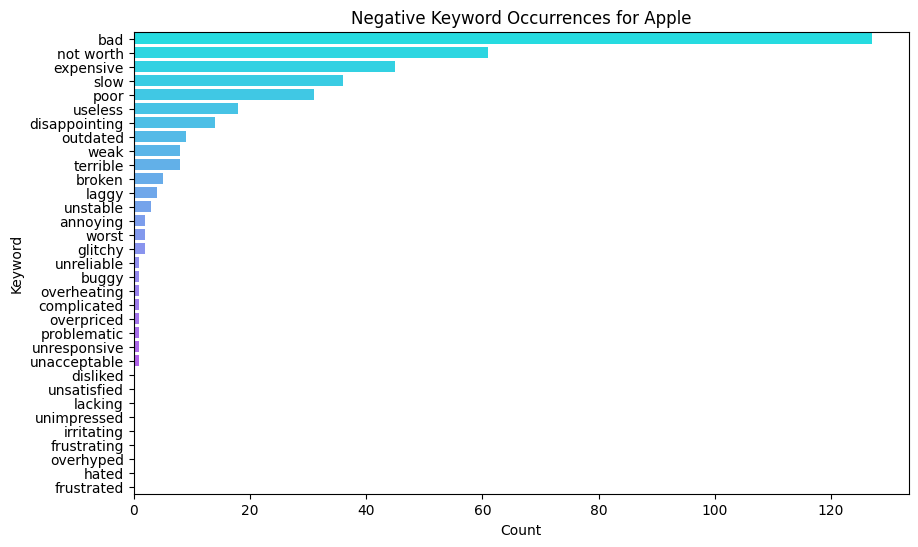

<ipython-input-123-2e949af9b185>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=apple_positive_counts.values, y=apple_positive_counts.index, palette='cool')


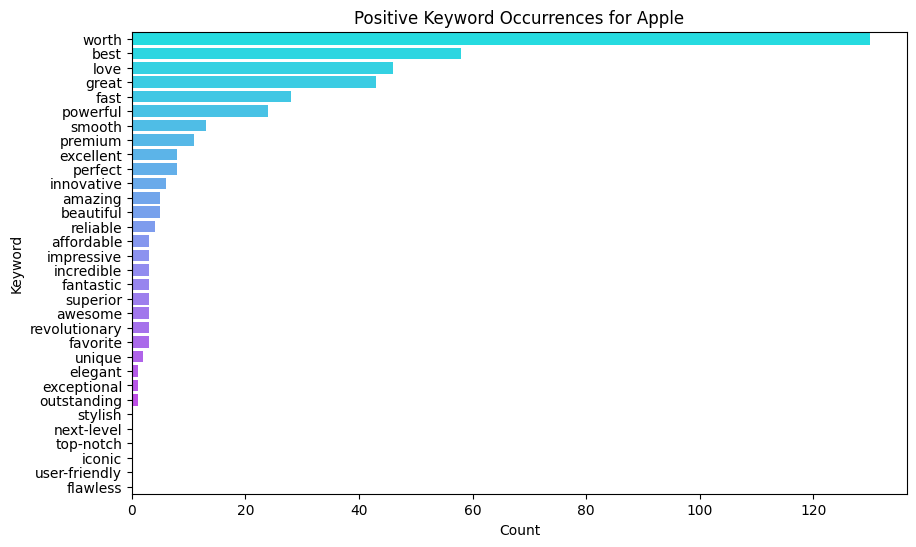

<ipython-input-123-2e949af9b185>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=apple_character_counts.values, y=apple_character_counts.index, palette='cool')


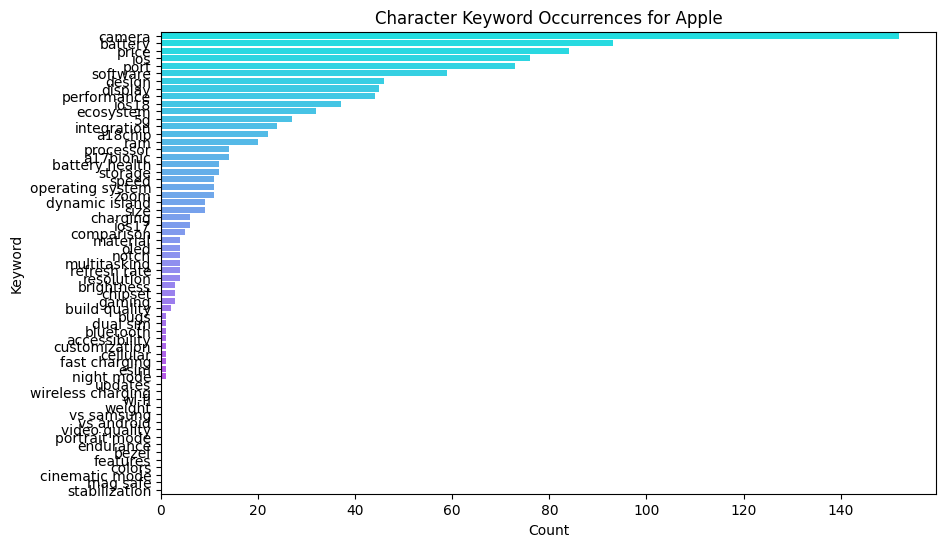


Character Keyword Counts for Apple:
camera            152
battery            93
price              84
ios                76
port               73
                 ... 
features            0
colors              0
cinematic mode      0
mag safe            0
stabilization       0
Length: 61, dtype: int64
Negative Keyword Counts for Apple:
bad              127
not worth         61
expensive         45
slow              36
poor              31
useless           18
disappointing     14
outdated           9
weak               8
terrible           8
broken             5
laggy              4
unstable           3
annoying           2
worst              2
glitchy            2
unreliable         1
buggy              1
overheating        1
complicated        1
overpriced         1
problematic        1
unresponsive       1
unacceptable       1
disliked           0
unsatisfied        0
lacking            0
unimpressed        0
irritating         0
frustrating        0
overhyped          0
hated     

In [123]:
# Plot Apple graphs
plt.figure(figsize=(10, 6))
sns.barplot(x=apple_negative_counts.values, y=apple_negative_counts.index, palette='cool')
plt.title('Negative Keyword Occurrences for Apple')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=apple_positive_counts.values, y=apple_positive_counts.index, palette='cool')
plt.title('Positive Keyword Occurrences for Apple')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=apple_character_counts.values, y=apple_character_counts.index, palette='cool')
plt.title('Character Keyword Occurrences for Apple')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

print("\nCharacter Keyword Counts for Apple:")
print(apple_character_counts)

print("Negative Keyword Counts for Apple:")
print(apple_negative_counts)

print("\nPositive Keyword Counts for Apple:")
print(apple_positive_counts)



<ipython-input-124-0e8cf9cc8f11>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=samsung_negative_counts.values, y=samsung_negative_counts.index, palette='cool')


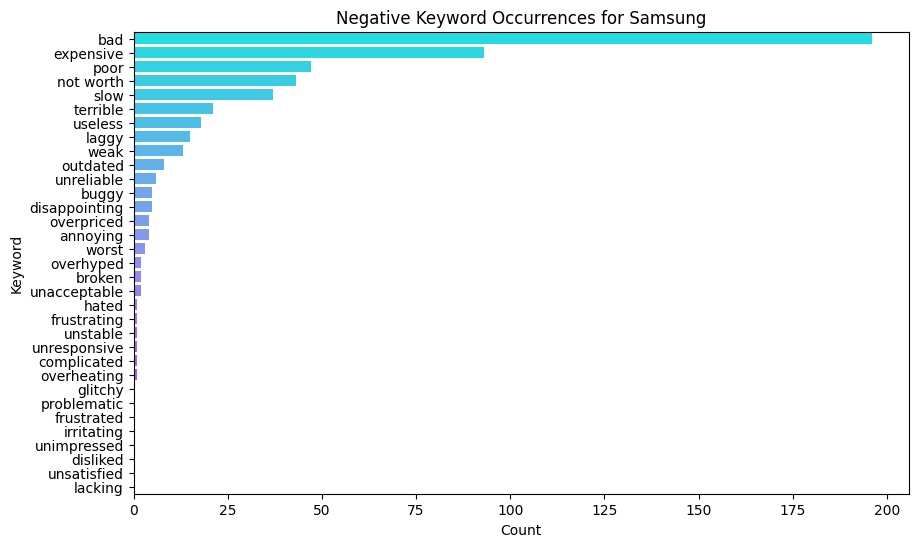

<ipython-input-124-0e8cf9cc8f11>:10: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=samsung_positive_counts.values, y=samsung_positive_counts.index, palette='cool')


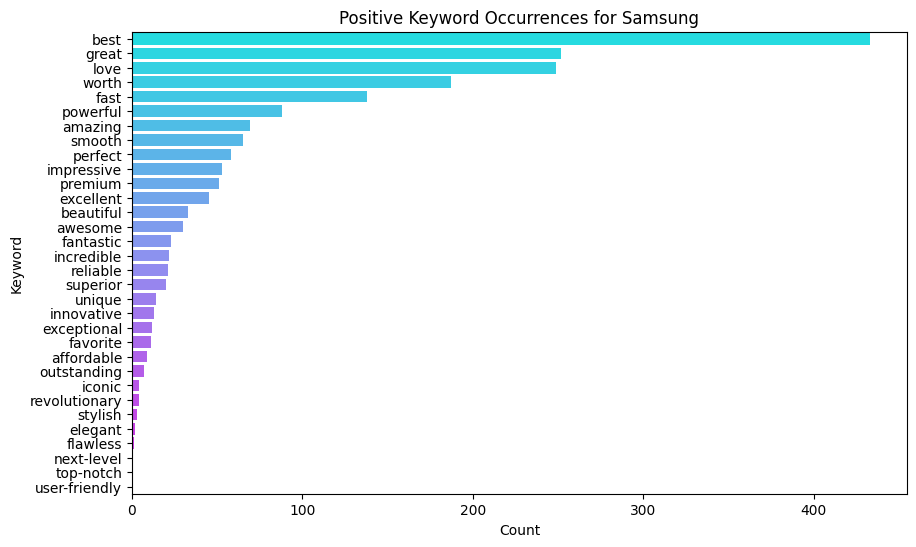

<ipython-input-124-0e8cf9cc8f11>:17: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=samsung_character_counts.values, y=samsung_character_counts.index, palette='cool')


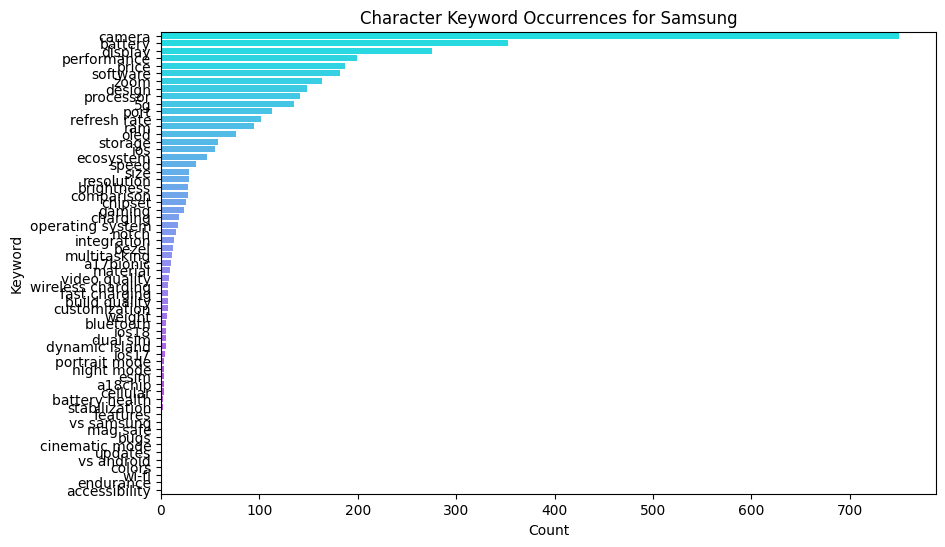


Character Keyword Counts for Samsung:
camera           750
battery          353
display          275
performance      199
price            187
                ... 
vs android         0
colors             0
wi-fi              0
endurance          0
accessibility      0
Length: 61, dtype: int64
Negative Keyword Counts for Samsung:
bad              196
expensive         93
poor              47
not worth         43
slow              37
terrible          21
useless           18
laggy             15
weak              13
outdated           8
unreliable         6
buggy              5
disappointing      5
overpriced         4
annoying           4
worst              3
overhyped          2
broken             2
unacceptable       2
hated              1
frustrating        1
unstable           1
unresponsive       1
complicated        1
overheating        1
glitchy            0
problematic        0
frustrated         0
irritating         0
unimpressed        0
disliked           0
unsatisfied      

In [124]:
# Plot Samsung graphs
plt.figure(figsize=(10, 6))
sns.barplot(x=samsung_negative_counts.values, y=samsung_negative_counts.index, palette='cool')
plt.title('Negative Keyword Occurrences for Samsung')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=samsung_positive_counts.values, y=samsung_positive_counts.index, palette='cool')
plt.title('Positive Keyword Occurrences for Samsung')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

plt.figure(figsize=(10, 6))
sns.barplot(x=samsung_character_counts.values, y=samsung_character_counts.index, palette='cool')
plt.title('Character Keyword Occurrences for Samsung')
plt.xlabel('Count')
plt.ylabel('Keyword')
plt.show()

print("\nCharacter Keyword Counts for Samsung:")
print(samsung_character_counts)

print("Negative Keyword Counts for Samsung:")
print(samsung_negative_counts)

print("\nPositive Keyword Counts for Samsung:")
print(samsung_positive_counts)



# LABELLING DATA WITH VADER

In [125]:
# Import the Necessary Libraries
from nltk.sentiment.vader import SentimentIntensityAnalyzer # To calculate sentiment scores
# Download the VADER lexicon
nltk.download('vader_lexicon') # to compute sentiment scores including wprds, phrases and emojis

# Initialize the Sentiment Analyzer
sia = SentimentIntensityAnalyzer()

# Apply VADER sentiment analysis
df['sentiment_scores'] = df['cleaned_text'].apply(lambda x: sia.polarity_scores(x))
df['compound'] = df['sentiment_scores'].apply(lambda score_dict: score_dict['compound'])

# Label Sentiments
def label_sentiment(compound_score):
    if compound_score >= 0.34:
        return 'Positive'
    elif compound_score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

df['sentiment'] = df['compound'].apply(label_sentiment)

# Save the Labeled Data
df.to_csv('labeled_tweets.csv', index=False)


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


The labeled data is save to a new csv file, labeled_tweets.csv.

# Sentiment Visualisation

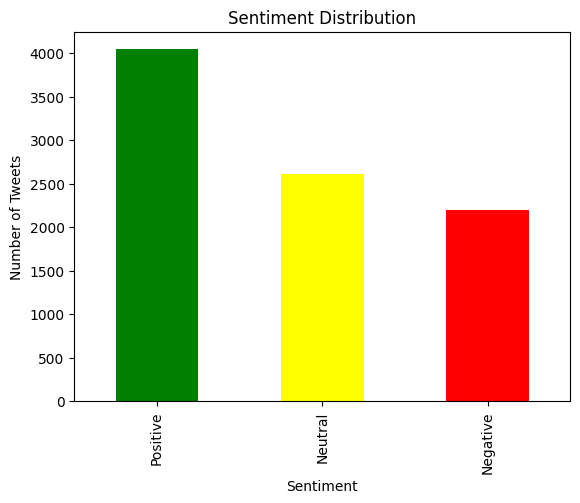

sentiment
Positive    4044
Neutral     2614
Negative    2192
Name: count, dtype: int64


In [126]:
# Visualize the distribution of Sentiment (Positive, Negative & Neutral)
import matplotlib.pyplot as plt
sentiment_counts = df['sentiment'].value_counts()
sentiment_counts.plot(kind='bar', color=['green', 'yellow', 'red'])
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Number of Tweets')
plt.show()

print(sentiment_counts)

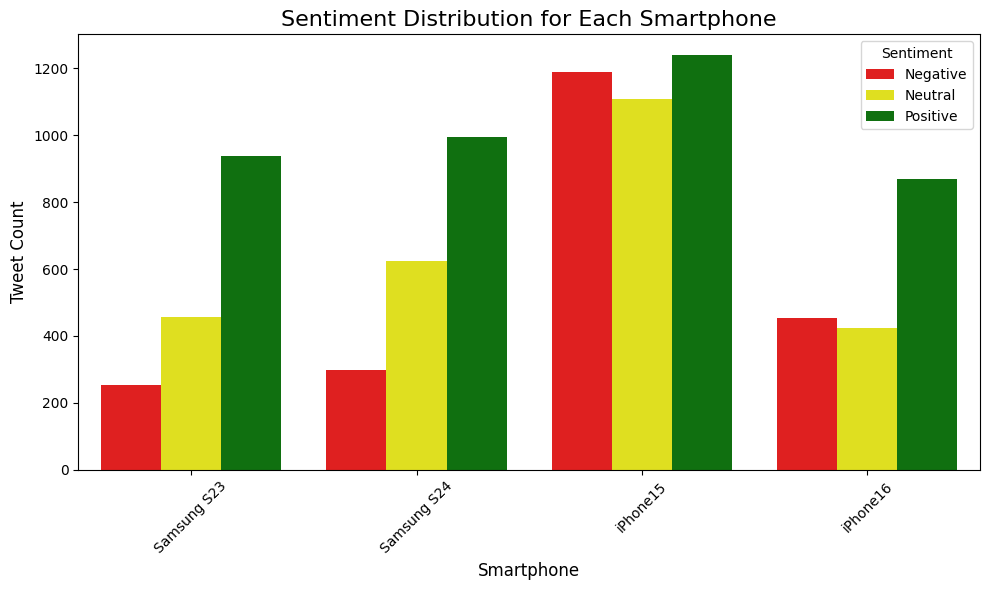

In [127]:
# Count the sentiment distribution for each smartphone
sentiment_counts = df.groupby(['smartphone', 'sentiment']).size().reset_index(name='count')

# Pivot the data for easier visualization
pivot_data = sentiment_counts.pivot(index='smartphone', columns='sentiment', values='count').fillna(0)

# Define a custom color palette: Negative = Red, Positive = Green, Neutral = Yellow
custom_palette = {
    'Negative': 'red',
    'Positive': 'green',
    'Neutral': 'yellow'
}

# Plot the sentiment distribution with the custom color palette
plt.figure(figsize=(10, 6))
sns.barplot(x='smartphone', y='count', hue='sentiment', data=sentiment_counts, palette=custom_palette)


# Add labels and title
plt.title('Sentiment Distribution for Each Smartphone', fontsize=16)
plt.xlabel('Smartphone', fontsize=12)
plt.ylabel('Tweet Count', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Sentiment')
plt.tight_layout()

# Show the plot
plt.show()

In [128]:
# Import necessary libraries
from collections import defaultdict


# Features to analyze
features = ['design', 'display', 'camera', 'performance', 'battery', 'software', 'price']

# Function to extract adjectives using POS tagging
def extract_adjectives(text, feature):
    """
    Extract adjectives related to a specific feature in the text.
    """
    words = nltk.word_tokenize(text)
    pos_tags = nltk.pos_tag(words)
    adjectives = []
    for idx, (word, tag) in enumerate(pos_tags):
        if word == feature:
            # Look for adjectives in a window around the feature
            window = pos_tags[max(0, idx - 2):idx + 3]
            adjectives.extend([w for w, t in window if t == 'JJ'])
    return adjectives

# Function to analyze sentiment for specific features
def analyze_sentiment_with_adjectives(row, features):
    """
    Analyze sentiment for given features in the text, using the pre-labeled compound score
    and extracting adjectives with POS tagging.
    """
    sentiment_results = defaultdict(lambda: {'positive': 0, 'negative': 0, 'neutral': 0, 'adjectives': []})
    for feature in features:
        if feature in row['cleaned_text']:
            # Use the pre-calculated compound score
            compound = row['compound']
            if compound > 0.34:
                sentiment_results[feature]['positive'] += 1
            elif compound < -0.05:
                sentiment_results[feature]['negative'] += 1
            else:
                sentiment_results[feature]['neutral'] += 1
            # Extract adjectives using POS tagging
            adjectives = extract_adjectives(row['cleaned_text'], feature)
            sentiment_results[feature]['adjectives'].extend(adjectives)
    return sentiment_results

# Apply the updated function to the DataFrame
df['sentiment_results'] = df.apply(lambda row: analyze_sentiment_with_adjectives(row, features), axis=1)

# Summarize results by smartphone model
feature_sentiment_summary = defaultdict(lambda: defaultdict(dict))

for model, group in df.groupby('smartphone'):
    model_results = defaultdict(lambda: {'positive': 0, 'negative': 0, 'neutral': 0, 'adjectives': []})
    for sentiment in group['sentiment_results']:
        for feature, values in sentiment.items():
            for key in ['positive', 'negative', 'neutral']:
                model_results[feature][key] += values[key]
            model_results[feature]['adjectives'].extend(values['adjectives'])
    feature_sentiment_summary[model] = model_results

# Display summarized sentiment results
for model, results in feature_sentiment_summary.items():
    print(f"Smartphone Model: {model}")
    for feature, sentiment in results.items():
        print(f"Feature: {feature}, Positive: {sentiment['positive']}, Negative: {sentiment['negative']}, Neutral: {sentiment['neutral']}")
        print(f"Adjectives: {set(sentiment['adjectives'])}")


Smartphone Model: Samsung S23
Feature: camera, Positive: 233, Negative: 38, Neutral: 50
Adjectives: {'ai', 'samsunggalaxys23u', 'good', 'android', 'infrared', 'please', 'audio', 'outstanding', 'versatile', 'ultra', 'fancy', 'digital', 'great', 'nice', 'awesome', 'comprehensive', 'front', 'functional', 'pure', 'triple', 'dedicated', 'excite', 'iphone15promax', 'real', 'bug', 'large', 'same', 'ux', 'adaptive', 'similar', 'rear', 'superb', 'ultrawide', 'i', 'pen', 'impressive', 'much', 'new', 'lowlight', 'main', 's', 'professional', 'only', 'advanced', 'stunning', 'telephoto', 'oneplus', 'stellar', 'pretty', 'mobile', 'get', 'primary', 'unparalleled', 'unbelievable', 'phenomenal', 'stun', 'galaxy', 'disappointed', 'big', 'different', 'pro', 'brilliant', 'dslr', 'fantastic', 'samsunggalaxys23ultras', 'amazing', 'bad', 'os', 'current', 'superior', 'exact', 'blind', 'excellent', 'open', 'powerful', 'sleek', 'overtime', 'samsunggalaxys23ultra', 'buzz', 'possible', 'major', 'optical'}
Feature:

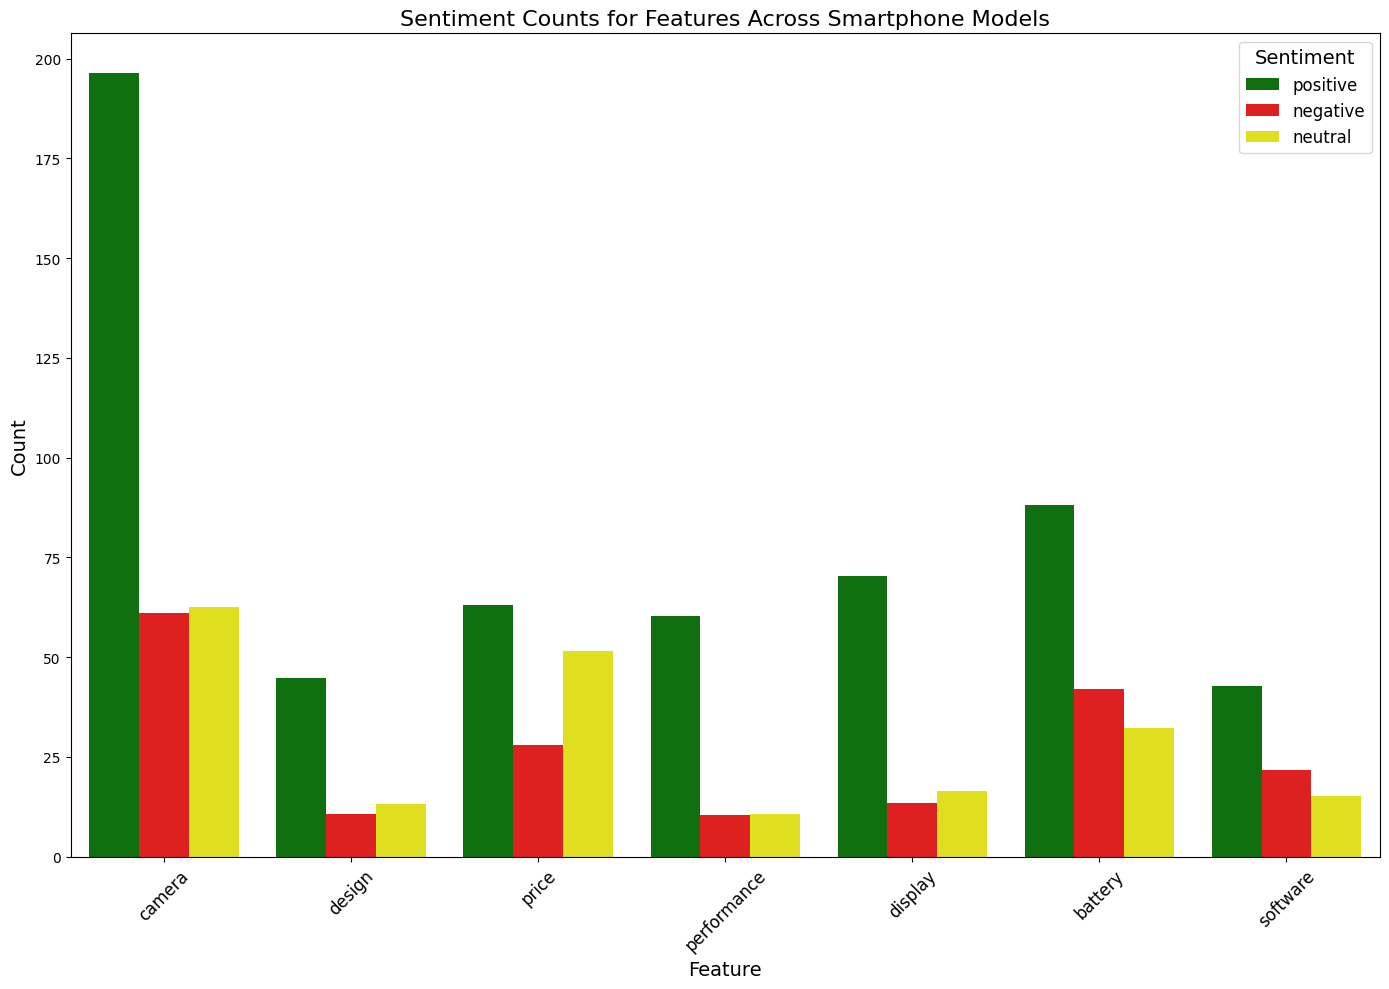

In [129]:
# Aggregate data for visualization
sentiment_counts = []

for model, results in feature_sentiment_summary.items():
    for feature, sentiment in results.items():
        sentiment_counts.append({
            'smartphone': model,
            'feature': feature,
            'positive': sentiment['positive'],
            'negative': sentiment['negative'],
            'neutral': sentiment['neutral']
        })

sentiment_df = pd.DataFrame(sentiment_counts)

# Define a custom color palette with red for negative, green for positive, yellow for neutral
custom_palette = {
    'negative': 'red',
    'positive': 'green',
    'neutral': 'yellow'
}

# Melt the dataframe for better compatibility with seaborn
melted_sentiment_df = sentiment_df.melt(id_vars=['smartphone', 'feature'],
                                        var_name='sentiment',
                                        value_name='count')

# Enhanced bar plot for sentiment with smartphone differentiation using the custom palette
plt.figure(figsize=(14, 10))
sns.barplot(data=melted_sentiment_df, x='feature', y='count', hue='sentiment', palette=custom_palette, errorbar=None)

# Adding title and labels
plt.title('Sentiment Counts for Features Across Smartphone Models', fontsize=16)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45, fontsize=12)
plt.legend(title='Sentiment', fontsize=12, title_fontsize=14)
plt.tight_layout()

# Show the plot
plt.show()

/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:723: UserWarning: Using the barplot function without specifying `hue_order` is likely to produce an incorrect plot.
  warnings.warn(warning)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)
/usr/local/lib/python3.10/dist-packages/seaborn/axisgrid.py:854: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  func(*plot_args, **plot_kwargs)


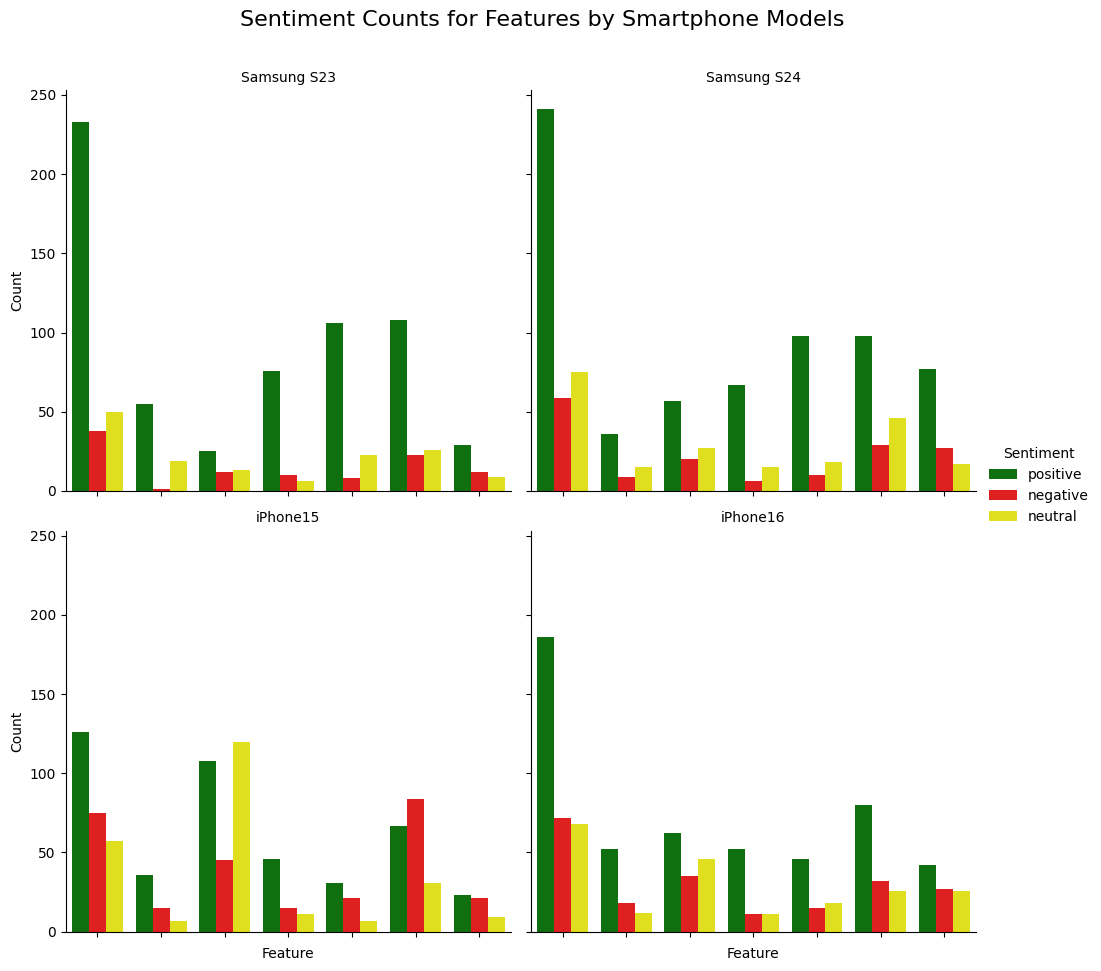

In [130]:
# Transform data for FacetGrid
melted_df = sentiment_df.melt(id_vars=['smartphone', 'feature'],
                              var_name='sentiment', value_name='count')
# Set color palette for consistency
sentiment_colors = {"positive": "green", "negative": "red", "neutral": "yellow"}
# Create FacetGrid
g = sns.FacetGrid(data=melted_df, col='smartphone', col_wrap=2, height=5, sharey=True)
g.map(sns.barplot, 'feature', 'count', 'sentiment', palette=sentiment_colors, ci=None, order=sentiment_df['feature'].unique())
g.set_titles("{col_name}")
g.set_axis_labels("Feature", "Count")
g.set_xticklabels(rotation=45)
g.add_legend(title="Sentiment")

plt.subplots_adjust(top=0.9)
g.fig.suptitle('Sentiment Counts for Features by Smartphone Models', fontsize=16)
plt.show()


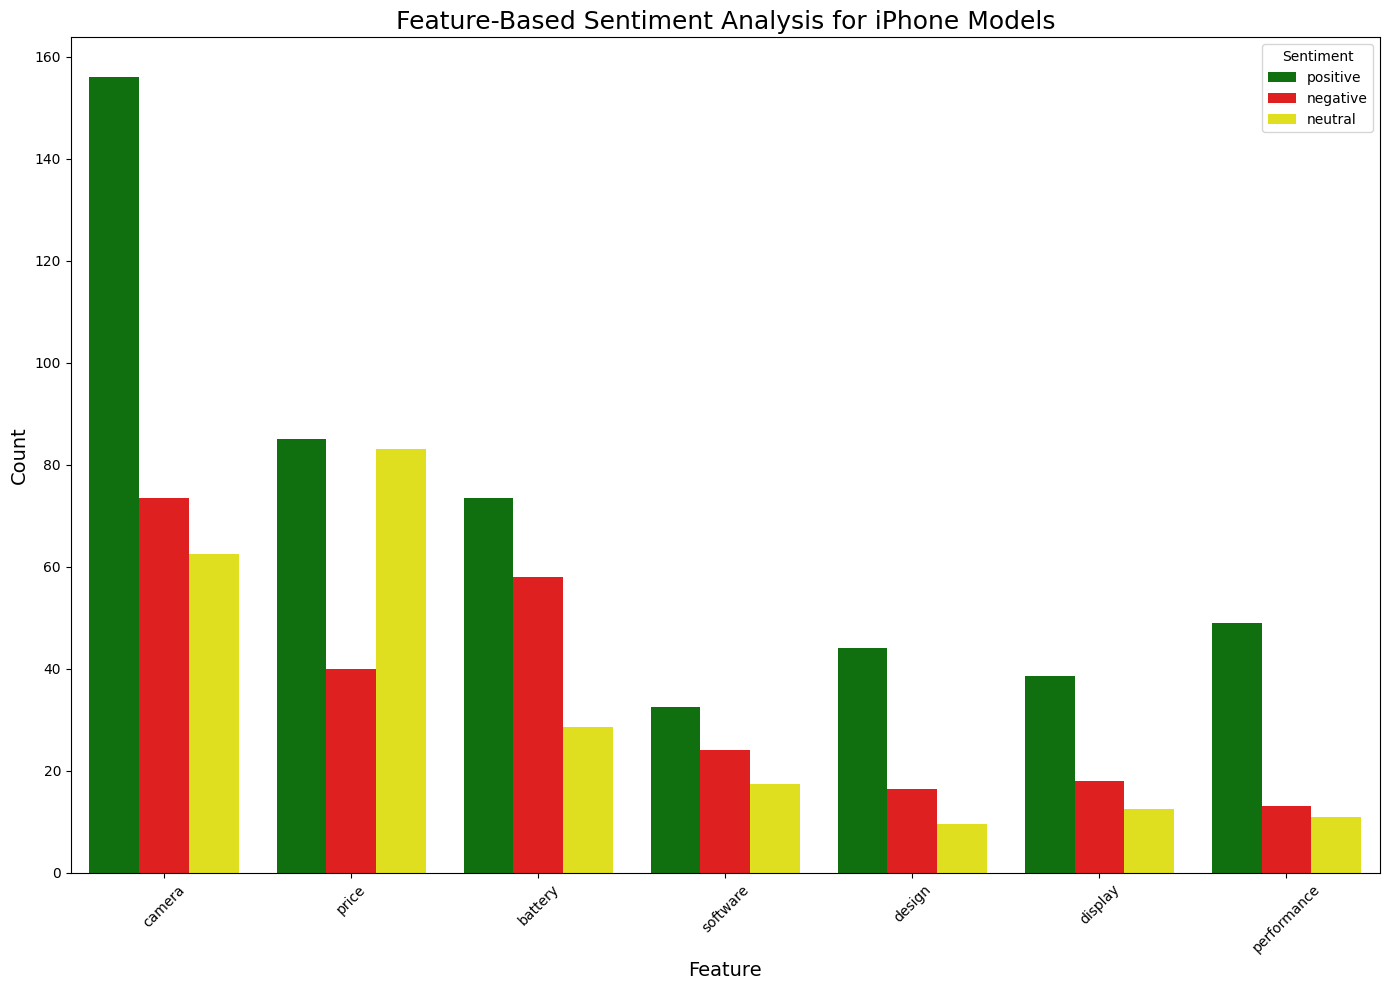

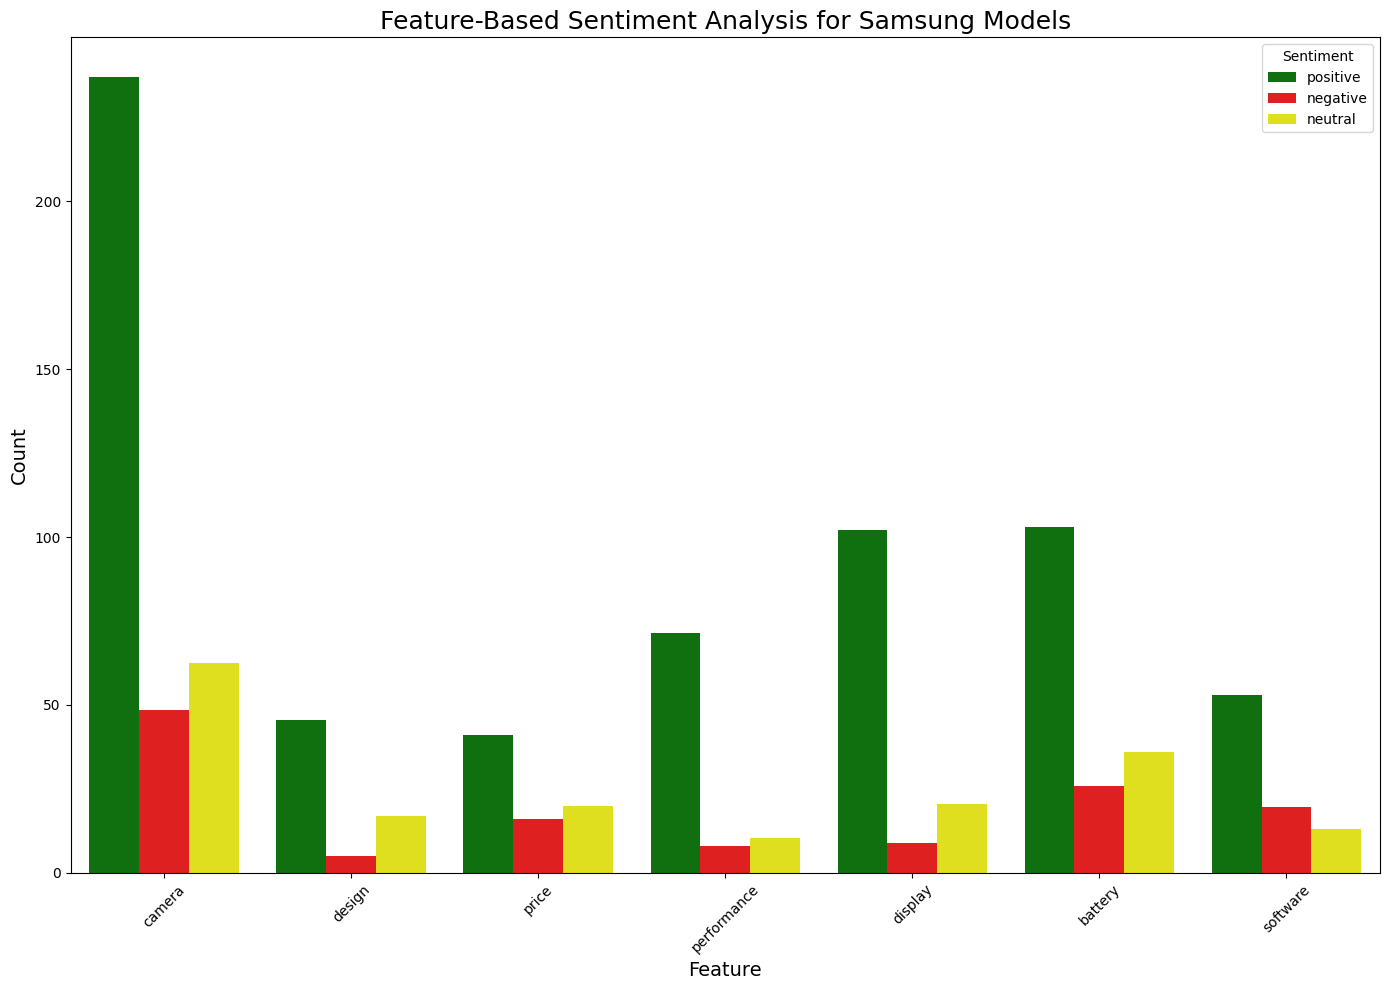

In [131]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Aggregate data for visualization (Separating Samsung and iPhone Models)
sentiment_counts = []

for model, results in feature_sentiment_summary.items():
    for feature, sentiment in results.items():
        sentiment_counts.append({
            'smartphone': model,
            'feature': feature,
            'positive': sentiment['positive'],
            'negative': sentiment['negative'],
            'neutral': sentiment['neutral']
        })

# Convert to DataFrame
sentiment_df = pd.DataFrame(sentiment_counts)

# Split data for Samsung and iPhone models
samsung_models = sentiment_df[sentiment_df['smartphone'].str.contains('Samsung', case=False)]
iphone_models = sentiment_df[sentiment_df['smartphone'].str.contains('iPhone', case=False)]

# Set color palette for consistency
sentiment_colors = {"positive": "green", "negative": "red", "neutral": "yellow"}

# Create the first bar plot for iPhone (Error bars disabled)
plt.figure(figsize=(14, 10))
sns.barplot(data=iphone_models.melt(id_vars=['smartphone', 'feature'],
                                    var_name='sentiment',
                                    value_name='count'),
            x='feature', y='count', hue='sentiment', palette=sentiment_colors, errorbar=None)
plt.title('Feature-Based Sentiment Analysis for iPhone Models', fontsize=18)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Sentiment')
plt.show()

# Create the second bar plot for Samsung (Error bars disabled)
plt.figure(figsize=(14, 10))
sns.barplot(data=samsung_models.melt(id_vars=['smartphone', 'feature'],
                                     var_name='sentiment',
                                     value_name='count'),
            x='feature', y='count', hue='sentiment', palette=sentiment_colors, errorbar=None)
plt.title('Feature-Based Sentiment Analysis for Samsung Models', fontsize=18)
plt.xlabel('Feature', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.xticks(rotation=45)
plt.tight_layout()
plt.legend(title='Sentiment')
plt.show()


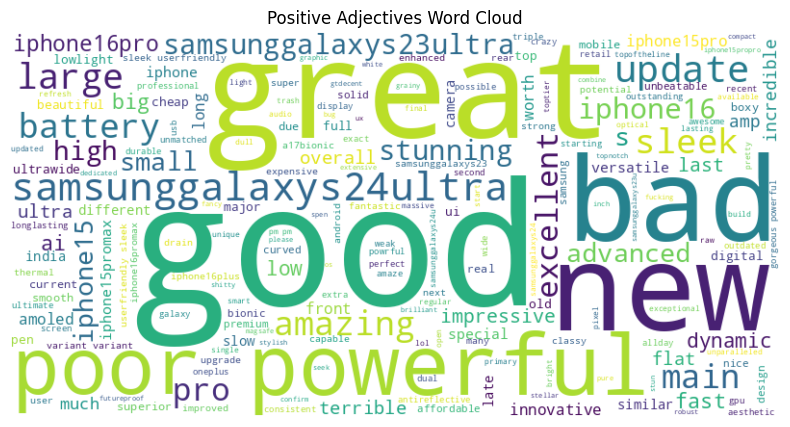

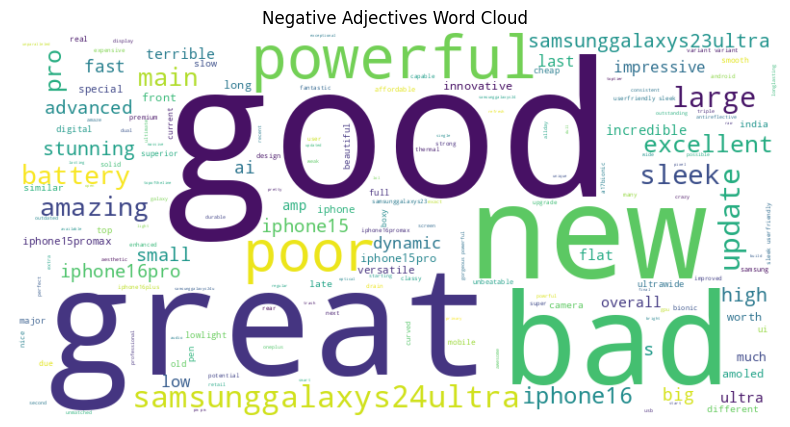

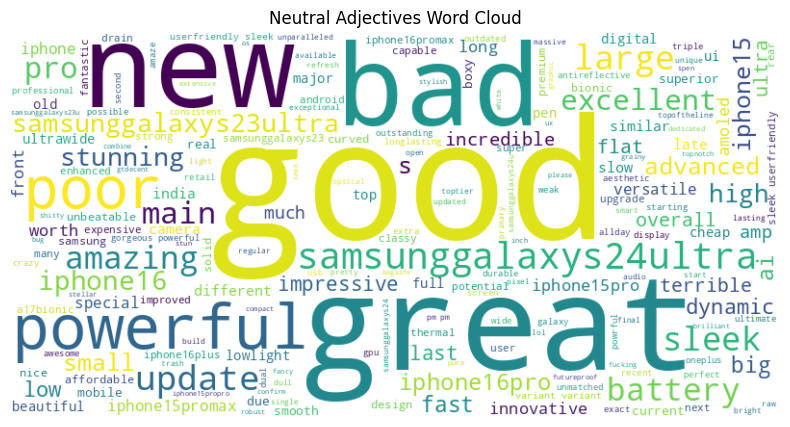

In [132]:
from wordcloud import WordCloud

# Generate word clouds for positive, negative, and neutral adjectives
for sentiment_type in ['positive', 'negative', 'neutral']:
    adjectives = []
    for model_results in feature_sentiment_summary.values():
        for feature_sentiment in model_results.values():
            adjectives.extend(feature_sentiment['adjectives'])
    wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(adjectives))
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(f'{sentiment_type.capitalize()} Adjectives Word Cloud')
    plt.show()


In [133]:
# Table summarizing sentiments for each feature
sentiment_table = sentiment_df.pivot_table(index='smartphone', columns='feature', values=['positive', 'negative', 'neutral'], aggfunc='sum')
print(sentiment_table)


            negative                                                  neutral  \
feature      battery camera design display performance price software battery   
smartphone                                                                      
Samsung S23       23     38      1       8          10    12       12      26   
Samsung S24       29     59      9      10           6    20       27      46   
iPhone15          84     75     15      21          15    45       21      31   
iPhone16          32     72     18      15          11    35       27      26   

                           ...                            positive         \
feature     camera design  ... performance price software  battery camera   
smartphone                 ...                                              
Samsung S23     50     19  ...           6    13        9      108    233   
Samsung S24     75     15  ...          15    27       17       98    241   
iPhone15        57      7  ...          11   12

In [134]:
# Save the Labeled Data
df.to_csv('labeled_tweets2.csv', index=False)